In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
palette = 'mako'

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, max_error, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import LearningCurveDisplay, learning_curve

from keras import models, layers

In [2]:
df = pd.read_pickle('../datasets/processed.pkl')
df.drop(columns = ['data', 'segundos_depois_meia_noite'], inplace = True)
df.sample(5)

,consumo_energia,corrente_atrasada,corrente_principal,co2,potencia_atrasado,potencia_principal,estado_semana,dia_semana,tipo_carga
14763,2.95,0.00,16.92,0.000000,100.00,17.18,Final de Semana,Domingo,Carga leve
1293,12.96,0.94,5.15,0.010002,99.74,92.93,Final de Semana,Domingo,Carga maxima
7659,44.42,1.76,0.76,0.020004,99.92,99.99,Dia da Semana,Quarta-feira,Carga media
1165,4.72,4.32,0.00,0.000000,73.77,100.00,Final de Semana,Sabado,Carga leve
33690,4.21,3.85,0.00,0.000000,73.80,100.00,Dia da Semana,Segunda-feira,Carga maxima


In [3]:
features = df.drop(columns = ['consumo_energia', 'potencia_principal', 'co2'])
target = df.consumo_energia

In [4]:
categorical = list(features.select_dtypes(include='category').columns)
numerical = list(features.select_dtypes(include='number').columns)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=777)

In [6]:
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical),
        ('cat', cat_transformer, categorical)
    ]
)

In [7]:
def create_model(model, preprocessor = preprocessor):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ("model", model)
    ])

In [8]:
def create_scores(model_list, train_x, train_y, test_x, test_y):
    scores = {
        "Algorithm": [],
        "Type": [],
        "R2": [],
        "Max Error": [],
        "Mean Absolute Error": [],
        "Mean Squared Error": []
    }
    
    for algorithm, model_ in model_list.items():
        for item in ['Train', 'Test']:
            model = model_
            model.fit(train_x, train_y)
            
            if item == 'Train':
                pred_y = model.predict(train_x)
                scores['Type'].append('Train')
                target = train_y
            else:
                pred_y = model.predict(test_x)
                scores['Type'].append('Test')
                target = test_y
                
            scores['Algorithm'].append(algorithm)
            scores['R2'].append( round( r2_score(target, pred_y), 2) )
            scores['Max Error'].append( round( max_error(target, pred_y), 2) )
            scores['Mean Absolute Error'].append( round( mae(target, pred_y), 2) )
            scores['Mean Squared Error'].append( round( mse(target, pred_y), 2) )

    return pd.DataFrame(scores)

In [9]:
model_list = {
    'Random Forest Regressor': create_model(RandomForestRegressor(random_state=777, n_jobs=-1)),
    'KNeighbors Regressor': create_model(KNeighborsRegressor()),
    'Decision Tree Regressor': create_model(DecisionTreeRegressor(random_state=777)),
    'Linear Regression': create_model(LinearRegression())
}

In [10]:
scores = create_scores(model_list, x_train, y_train, x_test, y_test)

In [11]:
def create_learning_curves(model_list: dict, features: pd.DataFrame, target: pd.Series, n_row: 2, n_col: 2):
    fig = plt.figure(figsize=(16, 10))
    for i, (algorithm, model_) in enumerate(model_list.items()):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        plt.title(f"{algorithm}", fontsize='large', fontweight='bold')
        plt.grid(visible=True, color='black', linewidth=.25)
        plt.xlabel("Number of Samples")
        plt.ylabel("R2 score")
        LearningCurveDisplay.from_estimator(model_, features, target, score_type='both', ax=ax, cv=5, scoring='r2', n_jobs=-1, random_state=777)
    fig.tight_layout()

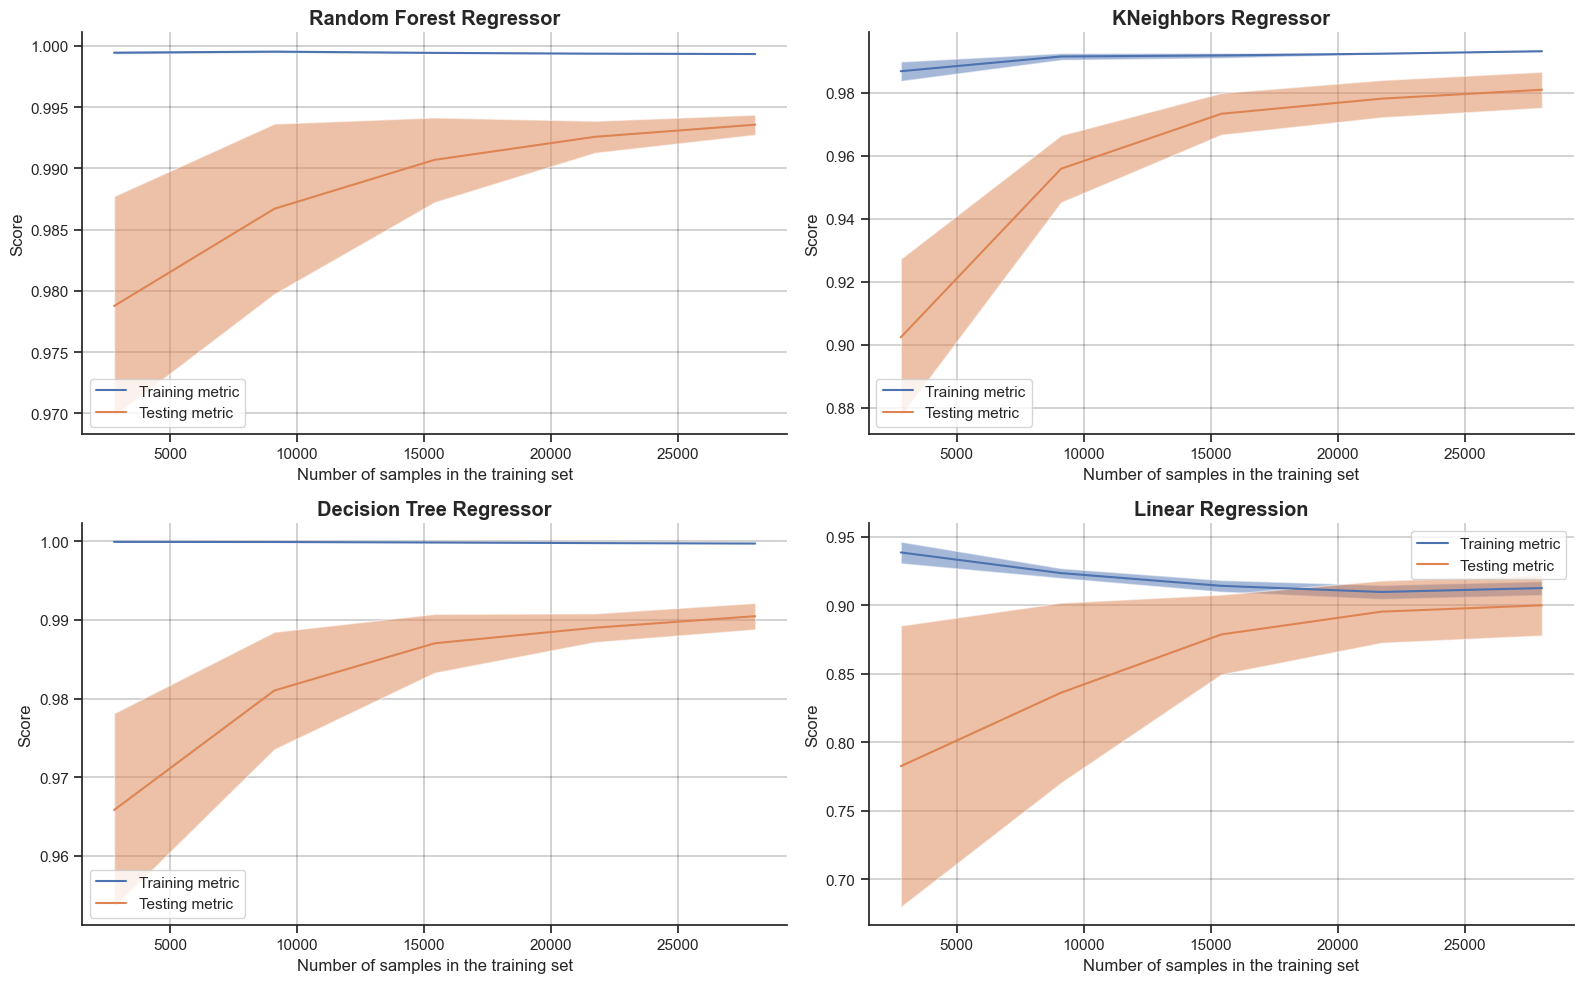

In [12]:
create_learning_curves(model_list, features, target, 2, 2)
plt.show()

In [13]:
def create_plot(results: pd.DataFrame, n_rows: int, n_cols: int, rot=45):
    fig = plt.figure(figsize=(16, 10))
    for i, title in enumerate(results.columns[2:]):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.barplot(data=results, x='Algorithm', y=title, hue='Type', palette=palette, ax=ax)
        for value in ax.containers:
            ax.bar_label(value)
        ax.tick_params(axis='x', labelrotation=rot, size=12)
        ax.tick_params(axis='y', size=12)
        ax.set(ylabel=None, xlabel=None)
        ax.set_title(f"{title.capitalize()}", fontsize='large', fontweight='bold', 
                style='italic', family='monospace')
        ax.grid(visible=True, color='black', linewidth=.25)
    fig.tight_layout()

In [14]:
create_plot(scores, 2, 2)
plt.show()

# Redes neurais

In [ ]:
features = df.drop(columns = ['consumo_energia', 'potencia_principal', 'co2'])
target = df.consumo_energia

label = LabelEncoder()
for col in features.select_dtypes(exclude=[np.number]).columns:
    features[col] = label.fit_transform(features[col])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=777)

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [ ]:
def create_network(len_input: int) -> models.Sequential:
    network = models.Sequential()
    network.add(layers.Dense(30, input_shape=(len_input, ), activation='relu'))
    network.add(layers.Dense(30))
    network.add(layers.Dense(1))
    network.compile(loss="mae", optimizer='Adam', metrics=["mse"])
    return network

model = create_network(features.shape[1])

history = model.fit(x_train_scaled, y_train_scaled, epochs=3, verbose=0, batch_size=10, 
                    validation_data=(x_test_scaled, y_test_scaled), shuffle=True)
pred_y = model.predict(x_test_scaled)

print(f'Algorithm: MLP')
print(f'R2 score: {r2_score(y_test_scaled, pred_y):}',)
print(f'Mean Absolute Error: {mae(y_test_scaled, pred_y):}')
print(f'Mean Squared Error: {mse(y_test_scaled, pred_y)}')

329/329 [==============================] - 0s 351us/step
Algorithm: MLP
R2 score: 0.9877400854008208
Mean Absolute Error: 0.06383838944302817
Mean Squared Error: 0.012173412529088243


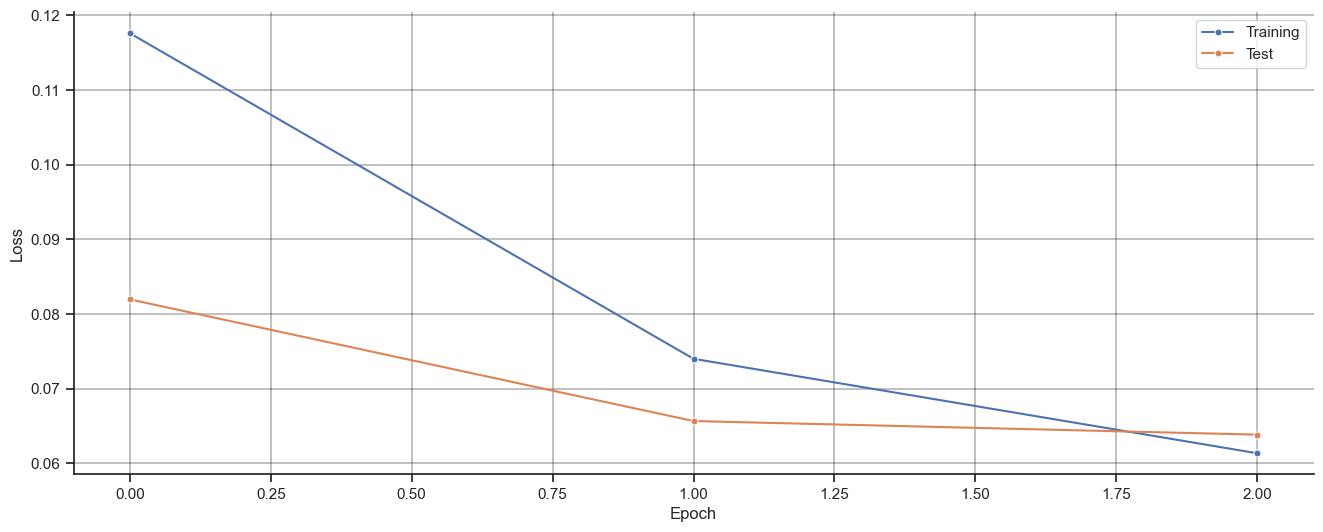

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

loss = pd.DataFrame({'training_loss': history.history["loss"], 'test_loss': history.history["val_loss"]})

epoch_count = np.arange(loss.shape[0])

sns.lineplot(data=loss, x=epoch_count, y='training_loss', label='Training', marker= '.', markersize=10, ax=ax)
sns.lineplot(data=loss, x=epoch_count, y='test_loss', label='Test', marker= '.', markersize=10, ax=ax)
ax.legend()
ax.set(xlabel='Epoch', ylabel='Loss')
ax.grid(visible=True, color='black', linewidth=.35)
plt.show()